### Import Dataset and Organize the Dataframe

In [1]:
# Let's import the necessary libraries
import pandas as pd

# Read in the dataset 
df = pd.read_csv('wgm_full_wave2_public_file_final_csv.csv',na_values=" ", keep_default_na=False,low_memory=False)

# Organizing the dataset:

# DEMOGRAPHIC INFORMATION
# Copy the original dataframe and select the columns associated with demograph information. 
#  These demographic factors are categorical variables; convert the datatype to 'categorical'
demographicInfo = df.copy()[['Global11Regions','Gender', 'Age','age_var3',
                             'Education','Household_Income','wbi',
                             'Subjective_Income','EMP_2010']].astype('category')

# First we add a new level/category of '99.0' to the feature:
demographicInfo['Household_Income'] = demographicInfo['Household_Income'].cat.add_categories(99.0)
demographicInfo['EMP_2010'] = demographicInfo['EMP_2010'].cat.add_categories(99.0)

# Impute the NaN values with '99.0' ('Don't Know/Refused')
demographicInfo['Household_Income'].fillna(99.0, inplace=True)
demographicInfo['EMP_2010'].fillna(99.0, inplace=True)


# QUESTIONNAIRE DATA
# Perception of science:
sciPercep = df.copy().iloc[:,6:28].astype('category')
sciPercep['W3'] = sciPercep['W3'].cat.add_categories(99.0) # Add a new level to 'W3'
sciPercep['W3'].fillna(99.0, inplace=True) # Impute the NaN values with the new level

# Impute the NaN entries with the values stated above
sciPercep['W4'].fillna(99.0, inplace=True)
sciPercep['W5B'].fillna(99.0, inplace=True)
sciPercep['W5D'].fillna(99.0, inplace=True)
sciPercep['W7C'].fillna(99.0, inplace=True)


# Perceptions about Climate Change
climateChange = df.copy().iloc[:,28:31].astype('category')
# Impute the NaN entries with the values stated above
climateChange['W14'].fillna(99.0, inplace=True)
climateChange['W15'].fillna(99.0, inplace=True)


# Perceptions of science with respect to COVID-19 pandemic
covidPercep = df.copy().iloc[:,31:38].astype('category')
# Impute the NaN entries with the values stated above
covidPercep['W15_1A'].fillna(99.0, inplace=True)
covidPercep['W15_1B'].fillna(99.0, inplace=True)
covidPercep['W15_1C'].fillna(99.0, inplace=True)
covidPercep['W15_1D'].fillna(99.0, inplace=True)
covidPercep['W15_1E'].fillna(99.0, inplace=True)
covidPercep['W15_2A'].fillna(99.0, inplace=True)
covidPercep['W15_2B'].fillna(99.0, inplace=True)


# Perceptions about physical and mental health:
sciHealth = df.copy().iloc[:,38:67].astype('category')
# Impute the NaN entries with the values stated above for MH3A to MH5 + MH7A
sciHealth['MH3A'].fillna(99.0, inplace=True)
sciHealth['MH3B'].fillna(99.0, inplace=True)
sciHealth['MH3C'].fillna(99.0, inplace=True)
sciHealth['MH3D'].fillna(99.0, inplace=True)
sciHealth['MH4A'].fillna(99.0, inplace=True)
sciHealth['MH4B'].fillna(99.0, inplace=True)
sciHealth['MH5'].fillna(99.0, inplace=True)
sciHealth['MH7A'].fillna(99.0, inplace=True)
# Impute the NaN entries with the values stated above for MH1 and MH6
sciHealth['MH1'].fillna(99, inplace=True)
sciHealth['MH6'].fillna(99, inplace=True)


# Social Media Usage
socialMedia = df.copy().iloc[:,67:70].astype('category')
# Impute the NaN values
socialMedia['W28'].fillna(99.0, inplace=True)
socialMedia['W29'].fillna(99.0, inplace=True)


# Religion
religion = df.copy()['W30'].astype('category')

# Impute missing values
religion.fillna(99.0, inplace=True)

Generating the final dataset used for Classification

In [2]:
questionDataset = pd.concat([sciPercep, climateChange, covidPercep,sciHealth.iloc[:,0:10], socialMedia, religion.to_frame()],axis=1)
# Remove 'Age' and keep 'age_var3'
demographicInfo = demographicInfo.drop('Age',axis=1)

dataset = pd.concat([demographicInfo, questionDataset],axis=1)
dataset.shape # 119 088 entries and 54 columns/features

(119088, 54)

In [3]:
dataset = dataset[(dataset['MH7A'] == 1.0) | (dataset['MH7A'] == 2.0)]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116810 entries, 0 to 119087
Data columns (total 54 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Global11Regions    116810 non-null  category
 1   Gender             116810 non-null  category
 2   age_var3           116810 non-null  category
 3   Education          116810 non-null  category
 4   Household_Income   116810 non-null  category
 5   wbi                116810 non-null  category
 6   Subjective_Income  116810 non-null  category
 7   EMP_2010           116810 non-null  category
 8   W1                 116810 non-null  category
 9   W2                 116810 non-null  category
 10  W3                 116810 non-null  category
 11  W4                 116810 non-null  category
 12  W5A                116810 non-null  category
 13  W5B                116810 non-null  category
 14  W5C                116810 non-null  category
 15  W5D                116810 non-null

### Classification

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Splitting the dataset into features and target/label:

In [5]:
y = dataset['MH7A'] # The label: MH7A 
y.shape # 119 088 entries

(116810,)

In [6]:
X = dataset.drop(columns='MH7A') # The independent variables/features used for classification
X.shape # 119 088 entries and 54 columns/features

(116810, 53)

Split the dataset into training/testing sets using a 70/30 split:

In [7]:
# 70% training and 30% test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [8]:
X_train.shape

(81767, 53)

In [9]:
X_test.shape

(35043, 53)

### Feature Selection

Based on the chi-squared test scores shown, let's set a threshold of 2000. Any features that have a score greater than 2000 will be included as a feature in future models.

Feature 0: 895.456901
Feature 1: 16.520788
Feature 2: 429.357539
Feature 3: 206.765457
Feature 4: 846.724313
Feature 5: 39.561801
Feature 6: 711.372076
Feature 7: 59.517958
Feature 8: 78.933518
Feature 9: 264.673228
Feature 10: 802.682457
Feature 11: 839.676847
Feature 12: 149.290457
Feature 13: 3299.105630
Feature 14: 18.832843
Feature 15: 8.387719
Feature 16: 13.242311
Feature 17: 1258.828622
Feature 18: 830.888446
Feature 19: 97.691066
Feature 20: 767.574079
Feature 21: 1735.630512
Feature 22: 1669.939171
Feature 23: 383.940229
Feature 24: 974.274333
Feature 25: 1157.068725
Feature 26: 2035.334654
Feature 27: 1943.582749
Feature 28: 246.275184
Feature 29: 3425.815844
Feature 30: 429.198579
Feature 31: 852.821591
Feature 32: 1377.413362
Feature 33: 11101.115091
Feature 34: 14531.825730
Feature 35: 15976.569347
Feature 36: 14023.354942
Feature 37: 12520.446012
Feature 38: 9385.945667
Feature 39: 9706.794076
Feature 40: 133.277412
Feature 41: 1182.391846
Feature 42: 10621.389196
Featur

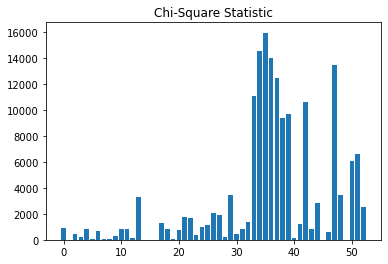

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# # Using the Chi-Squared test to identify features that are NOT independent of the target variable/label
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('Chi-Square Statistic')
plt.show()

In [11]:
selector = SelectKBest(score_func=chi2, k=17)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_fs = X_train.iloc[:,cols_idxs]

In [12]:
X_fs

,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
43560,2.0,1,2,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,99,99.0,99.0,1.0
62908,4.0,1,99,4.0,3.0,1.0,1.0,99.0,3.0,1.0,3.0,99.0,1.0,2,3.0,3.0,3.0
34789,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
55266,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
75584,99.0,1,3,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50736,1.0,3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2,3.0,3.0,4.0
99189,99.0,1,4,99.0,1.0,2.0,2.0,99.0,1.0,1.0,2.0,3.0,1.0,1,1.0,2.0,1.0
5214,3.0,1,1,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1,3.0,2.0,2.0
78640,3.0,1,3,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,3.0,2,2.0,3.0,1.0


In [13]:
# Let's add the demographic features into X_fs:
X_train_fs = pd.concat([X_train.iloc[:,1], X_fs],axis=1)
X_train_fs

,Gender,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
43560,2,2.0,1,2,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,99,99.0,99.0,1.0
62908,1,4.0,1,99,4.0,3.0,1.0,1.0,99.0,3.0,1.0,3.0,99.0,1.0,2,3.0,3.0,3.0
34789,2,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
55266,2,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
75584,2,99.0,1,3,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50736,2,1.0,3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2,3.0,3.0,4.0
99189,1,99.0,1,4,99.0,1.0,2.0,2.0,99.0,1.0,1.0,2.0,3.0,1.0,1,1.0,2.0,1.0
5214,2,3.0,1,1,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1,3.0,2.0,2.0
78640,2,3.0,1,3,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,3.0,2,2.0,3.0,1.0


In [14]:
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_test_fs = X_test.iloc[:,cols_idxs]

# The testing set to be used
X_test_fs = pd.concat([X_test.iloc[:,1],X_test_fs],axis=1)

X_test_fs.shape

(35043, 18)

Let's define some scoring metrics

In [15]:
# Define custom scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

#### Classification using smaller Feature Set

First let's update X_test with the new features:

In [16]:
X_train_fs.info() # 18 features now being used

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81767 entries, 43560 to 99685
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Gender  81767 non-null  category
 1   W5B     81767 non-null  category
 2   W11A    81767 non-null  category
 3   MH2B    81767 non-null  category
 4   W15_1A  81767 non-null  category
 5   W15_1B  81767 non-null  category
 6   W15_1C  81767 non-null  category
 7   W15_1D  81767 non-null  category
 8   W15_1E  81767 non-null  category
 9   W15_2A  81767 non-null  category
 10  W15_2B  81767 non-null  category
 11  MH3B    81767 non-null  category
 12  MH3D    81767 non-null  category
 13  MH5     81767 non-null  category
 14  MH6     81767 non-null  category
 15  W28     81767 non-null  category
 16  W29     81767 non-null  category
 17  W30     81767 non-null  category
dtypes: category(18)
memory usage: 2.0 MB


In [17]:
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_test_fs = X_test.iloc[:,cols_idxs]

# The testing set to be used
X_test_fs = pd.concat([X_test.iloc[:,1],X_test_fs],axis=1)

In [18]:
X_test_fs.shape

(35043, 18)

#### 10-fold Cross-validation

In [19]:
from sklearn.naive_bayes import CategoricalNB

In [20]:
# Create Decision Tree Classifier object
clf_NB = CategoricalNB()

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clf_NB, X_train_fs, y_train, cv=10, scoring=scoring)

# Print the results
print(cv_results)

{'fit_time': array([0.05602455, 0.0570209 , 0.05701232, 0.05501223, 0.05700755,
       0.05701542, 0.06201458, 0.05801702, 0.06001425, 0.06301665]), 'score_time': array([0.01600361, 0.01500201, 0.01499724, 0.0149982 , 0.01500368,
       0.01498938, 0.01600313, 0.01699996, 0.0280056 , 0.01500082]), 'test_accuracy': array([0.79075456, 0.78305002, 0.78586279, 0.7791366 , 0.78733032,
       0.78635196, 0.78855326, 0.78620352, 0.78754892, 0.79586595]), 'test_precision': array([0.48305085, 0.45197169, 0.46326531, 0.43090316, 0.4704142 ,
       0.4640592 , 0.47450572, 0.46439628, 0.46806167, 0.50551876]), 'test_recall': array([0.27159023, 0.2662299 , 0.27039905, 0.23585468, 0.28409768,
       0.26146516, 0.27142857, 0.26801668, 0.25312686, 0.27278142]), 'test_f1_score': array([0.34769348, 0.33508246, 0.34148176, 0.30484988, 0.35425176,
       0.33447619, 0.34532374, 0.33987915, 0.32856591, 0.35435203])}


In [23]:
# 10-fold cross-validation
print("Naive Bayes F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

Naive Bayes F1-score
Mean: 0.33859563709018037
Std: 0.013784328384593718


#### Using the Testing Set:

In [24]:
# create model object
clf_NB = CategoricalNB()

# fit the model
clf_NB.fit(X_train_fs, y_train)

# Predicting labels for the Test Set
y_pred_NB = clf_NB.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_NB))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 1919  5261]
 [ 2153 25710]]


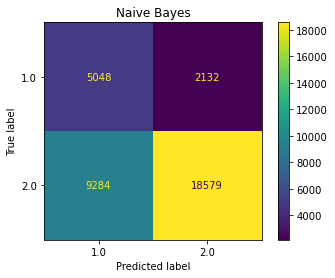

In [38]:
cm = confusion_matrix(y_test, y_pred_NB, labels=clf_NB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_NB.classes_)
disp.plot()
plt.title('Naive Bayes')
plt.show()

In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred_NB))
print("Precision:", precision_score(y_test, y_pred_NB))
print("Recall:", recall_score(y_test, y_pred_NB))
print("F1 Score:", f1_score(y_test, y_pred_NB))

Accuracy: 0.7884313557629199
Precision: 0.4712671905697446
Recall: 0.2672701949860724
F1 Score: 0.3410949164592961


### Balancing the dataset
Let's apply an imbalance treatment by undersampling the majority class (i.e. 'No' to MH7A)

In [27]:
from imblearn.under_sampling import RandomUnderSampler

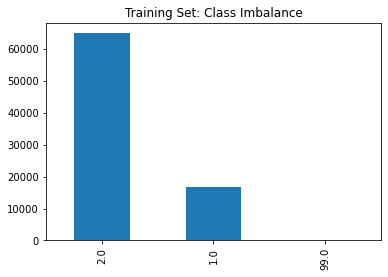

In [28]:
y_train.value_counts().plot(kind='bar', title='Training Set: Class Imbalance');

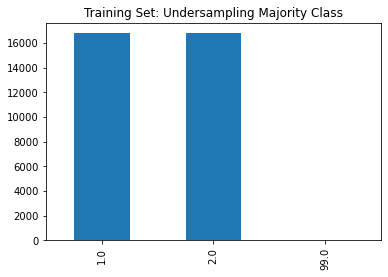

In [29]:
rus = RandomUnderSampler(random_state=1)
X_rus, y_rus = rus.fit_resample(X_train_fs, y_train)
y_rus.value_counts().plot(kind='bar', title='Training Set: Undersampling Majority Class');

In [30]:
# create model object
clf_NB = CategoricalNB()

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clf_NB, X_rus, y_rus, cv=10, scoring=scoring)

# Print the results
print(cv_results)

{'fit_time': array([0.02300453, 0.02100468, 0.02100468, 0.01999331, 0.01999879,
       0.02100492, 0.02100468, 0.02001572, 0.02102208, 0.02100325]), 'score_time': array([0.0080018 , 0.00800729, 0.00799608, 0.00800729, 0.00800753,
       0.0080018 , 0.0080018 , 0.0080018 , 0.00799179, 0.00801301]), 'test_accuracy': array([0.68442989, 0.67639178, 0.6855271 , 0.67153067, 0.68225134,
       0.69833234, 0.68820727, 0.70041691, 0.68433591, 0.68374032]), 'test_precision': array([0.67633675, 0.66742081, 0.67708926, 0.66475973, 0.67346939,
       0.6875    , 0.68140069, 0.69462117, 0.67859204, 0.67091413]), 'test_recall': array([0.7077381 , 0.70279929, 0.7093508 , 0.69207862, 0.70756403,
       0.72721858, 0.70696843, 0.71530673, 0.70041691, 0.72126266]), 'test_f1_score': array([0.69168121, 0.68465332, 0.69284468, 0.67814415, 0.69009585,
       0.70680174, 0.69394914, 0.70481221, 0.68933177, 0.69517796])}


In [31]:
# 10-fold cross-validation; Balanced Dataset
print("Naive Bayes F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

Naive Bayes F1-score
Mean: 0.6927492012380049
Std: 0.008056352757742538


In [36]:
# Fit Time
print("Naive Bayes Average Fit Time: {fit}".format(fit=np.mean(cv_results['fit_time'])))

Naive Bayes Average Fit Time: 0.020905661582946777


In [32]:
# create model object
clf_NB = CategoricalNB()

# fit the model
clf_NB.fit(X_rus, y_rus)

# Predicting labels for the Test Set
y_pred_NB = clf_NB.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_NB))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 5048  2132]
 [ 9284 18579]]


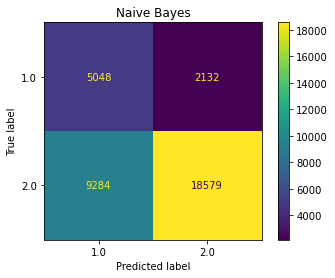

In [39]:
cm = confusion_matrix(y_test, y_pred_NB, labels=clf_NB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_NB.classes_)
disp.plot()
plt.title('Naive Bayes')
plt.show()

In [40]:
print("Accuracy:", accuracy_score(y_test, y_pred_NB))
print("Precision:", precision_score(y_test, y_pred_NB))
print("Recall:", recall_score(y_test, y_pred_NB))
print("F1 Score:", f1_score(y_test, y_pred_NB))
print("MCC:", matthews_corrcoef(y_test, y_pred_NB))

Accuracy: 0.6742288046114773
Precision: 0.3522188110521909
Recall: 0.7030640668523677
F1 Score: 0.4693194496095203
MCC: 0.30364233780918537


In [35]:
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

         1.0       0.35      0.70      0.47      7180
         2.0       0.90      0.67      0.76     27863

    accuracy                           0.67     35043
   macro avg       0.62      0.68      0.62     35043
weighted avg       0.79      0.67      0.70     35043

